In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xg
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
        
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import patsy
import pickle


### Wczytaj dane - w naszym przypadku dane o ślimakach

In [3]:
df = pd.read_csv('dane_slimak.csv', encoding = 'utf-8', delim_whitespace=True)

**Zawartoś bazy**

In [4]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


**Zamień wartości na wartości liczbowe. w naszym wypadku jest to tylko 1 kolumna <płeć>**

In [6]:
df['Sex'].replace({'I': 2, 'F': 1, 'M': 0},inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null int64
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


### Macierz korelacji

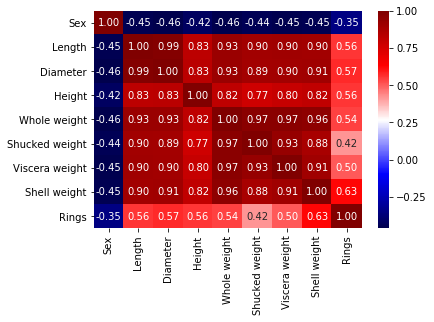

In [8]:
sns.heatmap(df.corr(), cmap = 'seismic', annot=True, fmt=".2f")

### Prepare features and target

In [9]:
columns_drop = ['Rings','Length']
X = df.drop(columns=columns_drop, axis = 1)
y = df['Rings']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 100)

## Modele 

### Linear regression


In [ ]:
clf_linear = LinearRegression()
clf_linear.fit(X_train, y_train)
accuracy_linear = clf_linear.score(X_val, y_val)
y_pred_linear = clf_linear.predict(X_val)
mae_linear = mean_absolute_error(y_val, y_pred_linear)

### SVR

In [ ]:
clf_SVR = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf_SVR.fit(X_train, y_train)
y_pred_SVR = clf_SVR.predict(X_val)
accuracy_SVR = clf_SVR.score( y_val,y_pred_SVR,)
mae_SVR = mean_absolute_error(y_val, y_pred_SVR)

### Random Forest Regressor

In [ ]:
clf_RFC = RandomForestRegressor(n_estimators=10, max_depth=10, min_samples_leaf=2, random_state=100)
clf_RFC.fit(X_train, y_train)
y_pred_RFC = clf_RFC.predict(X_val)
#accuracy_RFC = clf_RFC.score(y_val,y_pred_RFC)
mae_RFC = mean_absolute_error(y_val, y_pred_RFC)

### XGBoost

In [11]:
clf_XGB = xg.XGBRegressor()
clf_XGB.fit(X_train, y_train)
y_pred_XGB = clf_XGB.predict(X_val)
#accuracy_XGB = clf_XGB.score(y_val,y_pred_XGB)
mae_XGB = mean_absolute_error(y_val, y_pred_XGB)

In [12]:
mds = np.arange(3,5)
lrs = np.arange(0.05,0.35,0.10)
n_splits = 20
params = list(itertools.product(mds,lrs))
n= len(params)

data = {"max depth" : [], "learning_rate" :[],"mean_squared_error":[]}

for i, (md,lr) in enumerate(params):
    model = xg.XGBRegressor(max_depth=md,learning_rate=lr)
    cv = KFold(n_splits=n_splits)
    scorer = make_scorer(mean_squared_error)
    cv_result = cross_val_score(model,X_train,y_train,cv=cv,scoring=scorer)

    data["mean_squared_error"].extend(cv_result)
    data["max depth"].extend([md]*n_splits)
    data["learning_rate"].extend([lr]*n_splits)

    print("{}/{}".format(i,n))

df = pd.DataFrame(data=data)
min_error = df["mean_squared_error"].min()
max_error = df["mean_squared_error"].max()

out = {
    "min_error":min_error,
    "max_error" : max_error,
    "df":df
}

0/6
1/6
2/6
3/6
4/6
5/6


In [21]:
print(out)

{'min_error': 3.4318765430468305, 'max_error': 6.517264528241883, 'df':      max depth  learning_rate  mean_squared_error
0            3           0.05            6.210887
1            3           0.05            4.123911
2            3           0.05            6.028601
3            3           0.05            4.331790
4            3           0.05            4.109387
5            3           0.05            5.064005
6            3           0.05            5.471036
7            3           0.05            4.787739
8            3           0.05            4.447524
9            3           0.05            5.603879
10           3           0.05            4.190109
11           3           0.05            5.459442
12           3           0.05            5.535572
13           3           0.05            5.344358
14           3           0.05            5.169577
15           3           0.05            3.431877
16           3           0.05            3.714566
17           3           0.0

In [ ]:
#DecisionTreeRegressor
clf_DTR = DecisionTreeRegressor()
clf_DTR.fit(X_train, y_train)
y_pred_DTR = clf_DTR.predict(X_val)
#accuracy_DTR = clf_DTR.score(y_val,y_pred_DTR)
mae_DTR = mean_absolute_error(y_val, y_pred_DTR)

In [ ]:
# print('MAE Linear regression:', mae_linear)
# print('MAE SVR:', mae_SVR)
# print('MAE RFC:', mae_RFC)
print('MAE XBG:', mae_XGB)
# print('MAE DTR:', mae_DTR)